In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
import warnings
from tqdm import tqdm
from IPython.display import Image
import seaborn as sns
import calmap
from datetime import datetime, timedelta
import math
from itertools import product
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error as mse

In [2]:
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/vlad/.local/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime', 'product']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# M5 Forecasting - Accuracy
Vladislav Molodtsov, Irina Shushpannikova

https://www.kaggle.com/c/m5-forecasting-accuracy/data

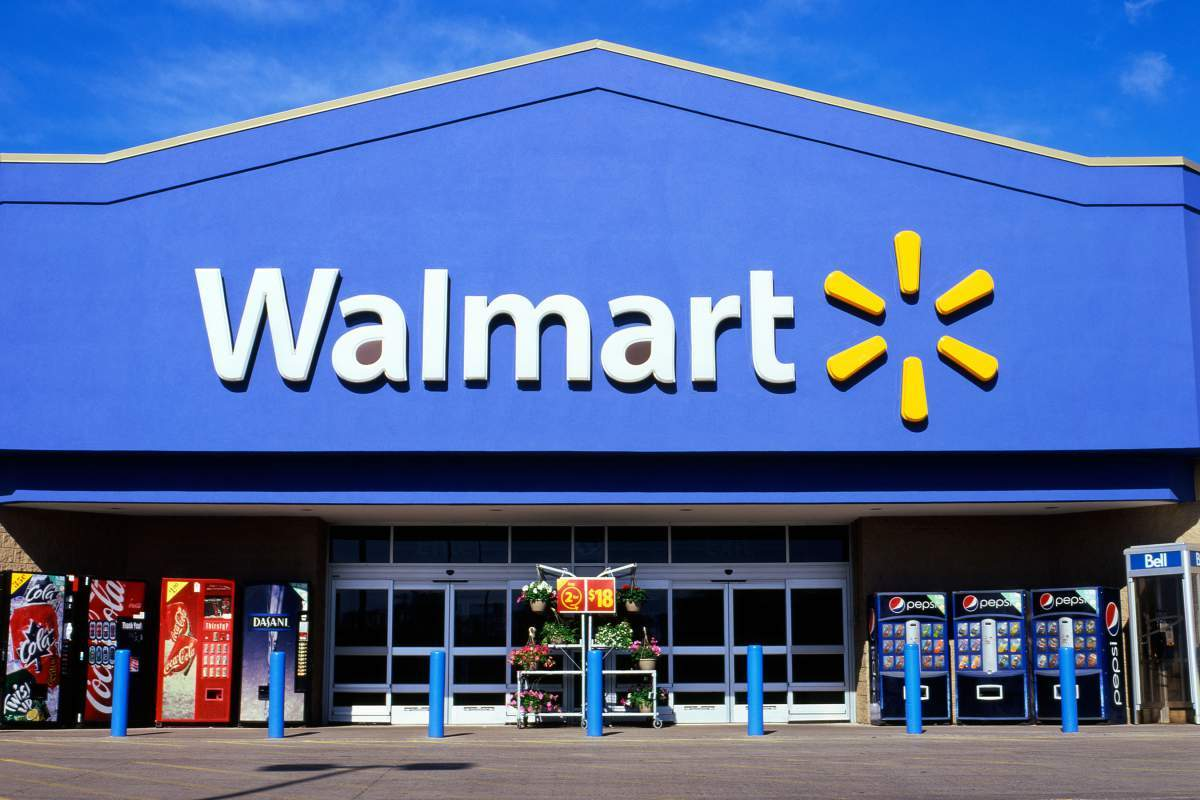

In [30]:
Image(filename='pics/view.jpg')

# Data exploration

### Available data:
* *sales_train_validation.csv* - daily sales
* *calendar.csv* - dates, holidays, discounts
* *sell_prices.csv* - commodity prices

In [3]:
sales_train_validation = pd.read_csv('sales_train_validation.csv')
sell_prices = pd.read_csv('sell_prices.csv')

In [131]:
sales_train_validation.iloc[:12,:12]

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0
5,HOBBIES_1_006_CA_1_validation,HOBBIES_1_006,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0
6,HOBBIES_1_007_CA_1_validation,HOBBIES_1_007,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0
7,HOBBIES_1_008_CA_1_validation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,12,15,0,0,0,4
8,HOBBIES_1_009_CA_1_validation,HOBBIES_1_009,HOBBIES_1,HOBBIES,CA_1,CA,2,0,7,3,0,2
9,HOBBIES_1_010_CA_1_validation,HOBBIES_1_010,HOBBIES_1,HOBBIES,CA_1,CA,0,0,1,0,0,0


In [4]:
calendar = pd.read_csv('calendar.csv')
date=calendar.loc[:,['d','date']]
date.set_index('d', inplace=True)
date=date.reset_index(drop=True)
calendar.drop(index=np.arange(len(calendar)-1,len(calendar)-57, -1), inplace=True)

In [133]:
calendar.iloc[2:10,:]

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1
5,2011-02-03,11101,Thursday,6,2,2011,d_6,NaN,NaN,NaN,NaN,1,1,1
6,2011-02-04,11101,Friday,7,2,2011,d_7,NaN,NaN,NaN,NaN,1,0,0
7,2011-02-05,11102,Saturday,1,2,2011,d_8,NaN,NaN,NaN,NaN,1,1,1
8,2011-02-06,11102,Sunday,2,2,2011,d_9,SuperBowl,Sporting,NaN,NaN,1,1,1
9,2011-02-07,11102,Monday,3,2,2011,d_10,NaN,NaN,NaN,NaN,1,1,0


In [214]:
def plot_data(product, name="Product 1"):
    data=sales_train_validation[sales_train_validation.id == product].iloc[0]
    data=pd.DataFrame(data)
    data=data.drop(axis=0, labels=['id','item_id','dept_id','cat_id','store_id','state_id'])

    fig, ax = plt.subplots(figsize=(12,6))
    data.plot(title=name, fontsize=15, legend=False, ax=ax)

    ax.set_ylabel('Sales', size=25)
    ax.title.set_size(30)

    plt.show()

In [5]:
products_to_analyze = [
    'FOODS_1_006_CA_1_validation',
    'FOODS_1_016_CA_1_validation',
    'FOODS_1_018_CA_1_validation',
    'FOODS_1_024_CA_1_validation',
    'FOODS_1_054_CA_1_validation'
]

In [6]:
data = list()
for i, product in enumerate(products_to_analyze):
    df = pd.DataFrame(sales_train_validation[sales_train_validation.id == product].iloc[0])
    df = df.drop(axis=0, labels=['id','item_id','dept_id','cat_id','store_id','state_id'])
    df = df.reset_index(drop=True)
    df.columns = ["sales"]
    df.sales = df.sales.astype('int')

    df=pd.concat([df,date],axis=1)
    df.dropna(inplace=True)
    df['date']=pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    
    data.append(df)

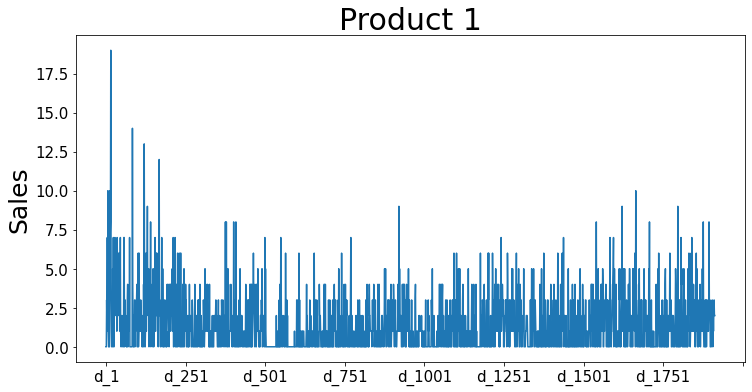

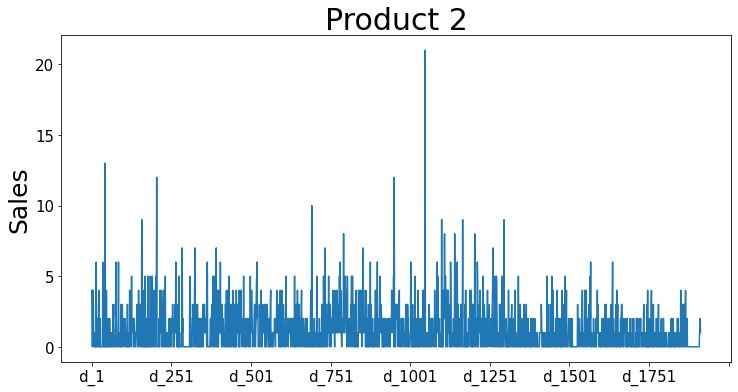

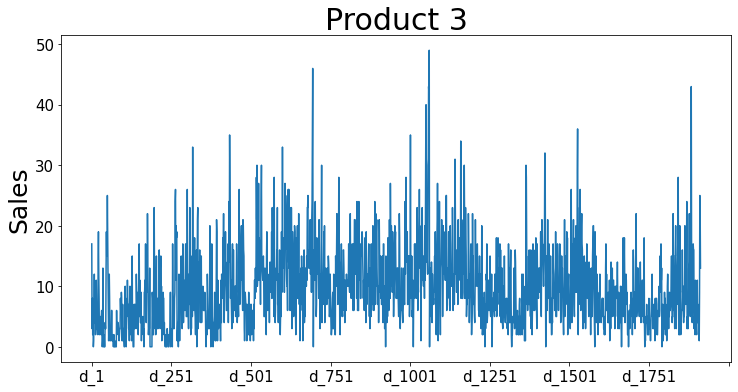

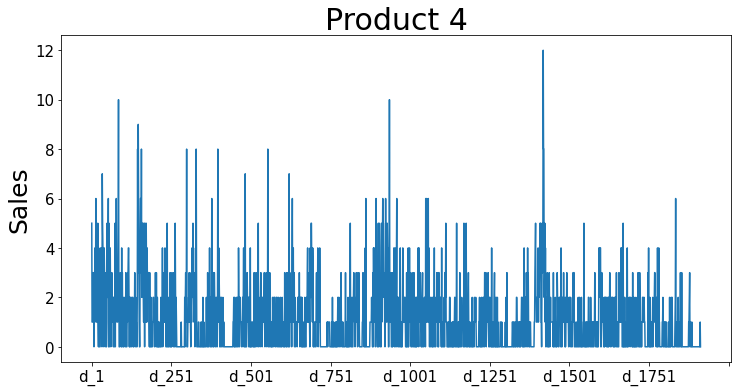

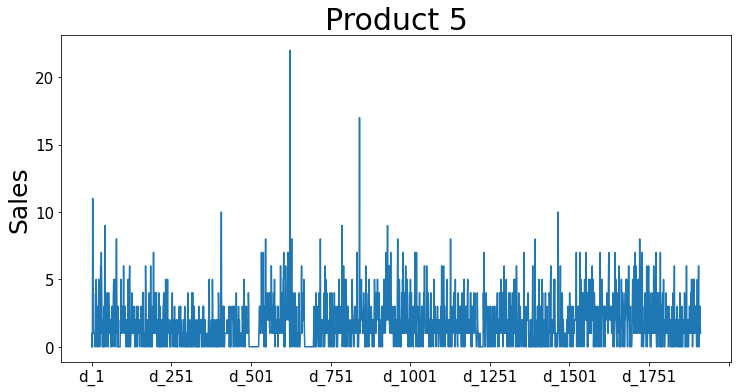

In [217]:
for i, product in enumerate(products_to_analyze):
    plot_data(product, "Product "+str(i+1))

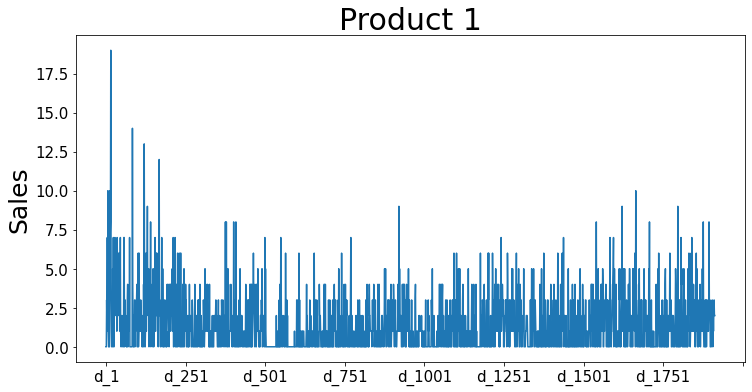

In [141]:
plotData(products_to_analyze[0])

In [7]:
def calendar_sales(number):
    year=2015
    n_graphs = min(number,len(data))
    fig, axes = plt.subplots(nrows=n_graphs, figsize=(16,12))
    
    for i in range(n_graphs):
        calmap.yearplot(data[i].sales, year=year, ax=axes[i])
        axes[i].yaxis.set_tick_params(labelsize=15)
        axes[i].xaxis.set_tick_params(labelsize=15)
        axes[i].set_title('Sales of Product '+str(i), fontdict={'fontsize':30})

    plt.tight_layout()
    plt.show()

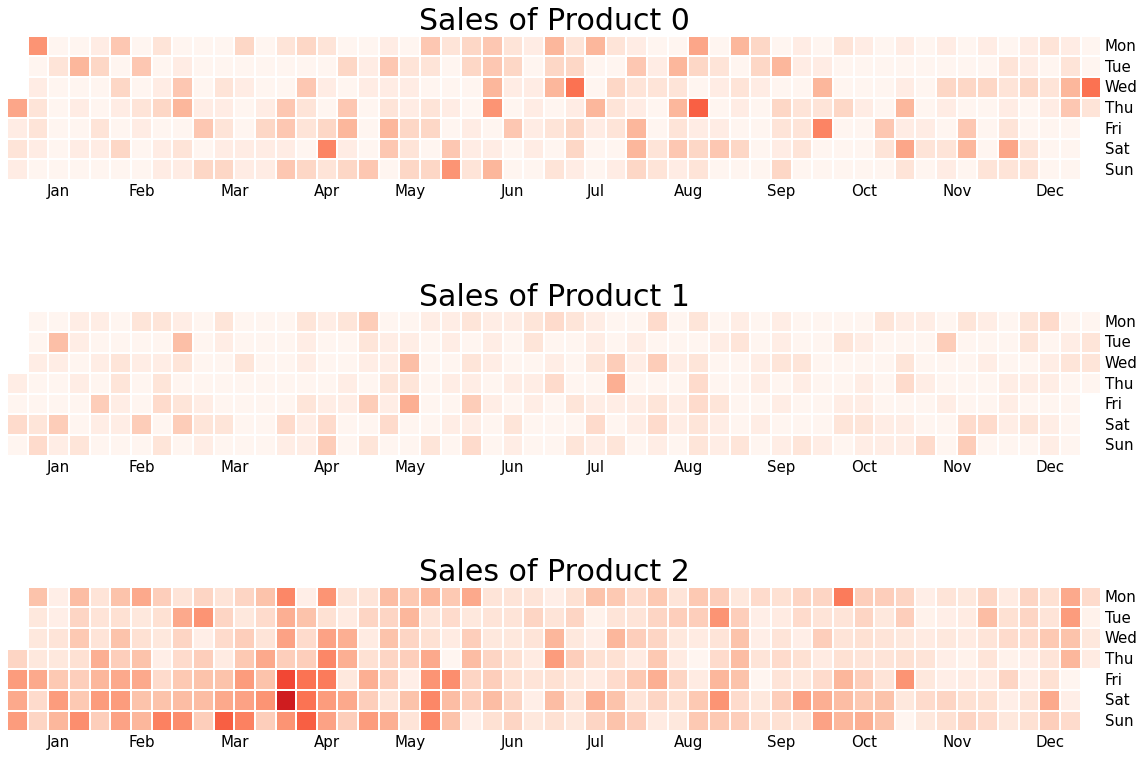

In [219]:
calendar_sales(3)

# Problem formulation

### Prediction of the next 28 days of sales - *Time Series Forecasting*

In [8]:
def add_lags(dataframe, lags):
    columns = list()
    
    for lag in lags:
        shifted = dataframe.shift(lag)
        shifted.columns = ['lag_'+str(lag)]
        columns.append(shifted)
        
    return pd.concat([dataframe, *columns], axis=1).dropna()

In [9]:
lags = [1,2,3,4,5,6,7]

for i in range(len(data)):
    data[i] = add_lags(data[i], lags)

In [10]:
data[0].head()

,sales,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
date,,,,,,,,
2011-02-05,1.0,10.0,2.0,7.0,1.0,3.0,0.0,0.0
2011-02-06,0.0,1.0,10.0,2.0,7.0,1.0,3.0,0.0
2011-02-07,0.0,0.0,1.0,10.0,2.0,7.0,1.0,3.0
2011-02-08,0.0,0.0,0.0,1.0,10.0,2.0,7.0,1.0
2011-02-09,0.0,0.0,0.0,0.0,1.0,10.0,2.0,7.0


In [284]:
# TODO: data - list of dataframes. please make train and test lists as well

train, test = train_test_split(data[0], shuffle=False, test_size=0.1)

print("Train:\tfrom", train.index.min().date(), "to", train.index.max().date())
print("Test:\tfrom", test.index.min().date(), "to", test.index.max().date())

Train:	from 2011-02-05 to 2015-10-16
Test:	from 2015-10-17 to 2016-04-24


In [285]:
# TODO: please make it lists as well

features_train = train.drop('sales', axis=1)
target_train = train['sales']
features_test = test.drop('sales', axis=1)
target_test = test['sales']

In [286]:
display(features_train.shape)
display(target_train.shape)
display(features_test.shape)
display(target_test.shape)

(1715, 7)

(1715,)

(191, 7)

(191,)

### Metrics

SMAPE - Symmetric Mean Absolute Percentage Error
$
\frac{1}{n}\sum\limits_{i=1}^n\frac{|y_i-\tilde{y_i}|}{(|y_i|+|\tilde{y_i}|)/2}\times100\%
$

In [320]:
def fittingShow(model, title):
    pred = model.predict(features_train)
    pred = pd.DataFrame(pred).set_index(target_train.index)[0]

    fig, axes = plt.subplots(figsize=(12,7))

    axes.set_title(title, fontdict={'fontsize':30}, pad=10)

    labelsize=15
    axes.yaxis.set_tick_params(labelsize=labelsize)
    axes.xaxis.set_tick_params(labelsize=labelsize)

    ind = np.arange(100,400)
    target_train[ind].plot(ax=axes)
    pred[ind].plot(ax=axes,color='r', alpha=0.7)

    axes.set_ylabel('Sales', fontsize=25)
    axes.set_xlabel('Date', fontsize=25)

    axes.legend(['Observed', 'Fitted'], fontsize=20, loc='upper right')

    plt.tight_layout()
    plt.show()
    
    print('RMSE: %.5f' % np.sqrt(mse(target_train, pred)))

In [307]:
def choose_best_parameters(model, param_search):
    cv = [(train,test) for train, test in TimeSeriesSplit(n_splits=8).split(features_train)] 

    gsearch = GridSearchCV(estimator=model, cv=cv,
                           param_grid=param_search, scoring='neg_mean_squared_error', n_jobs=-1, 
                           refit=True, return_train_score=True)

    gsearch.fit(features_train, target_train)

    return gsearch

In [311]:
def fit_optimal_model(model, param_search, number):
    best =  choose_best_parameters(model, param_search)
    print("Product",str(number))
    print("Optimal model:", best.best_estimator_)
    print("RMSE on train: ", str(round(np.sqrt(mse(target_train, best.predict(features_train))),3)))

    return best.best_estimator_

In [322]:
param_search = {'n_estimators' : range(100, 400, 20)}
# param_search = {'n_estimators' : range(100, 120, 20)}

In [323]:
# TODO: please make it lists as well
best_RFR = fit_optimal_model(RandomForestRegressor(), param_search, 1)

Product 1
Optimal model: RandomForestRegressor()
SMAPE on train:  95.327%
RMSE on train:  0.872


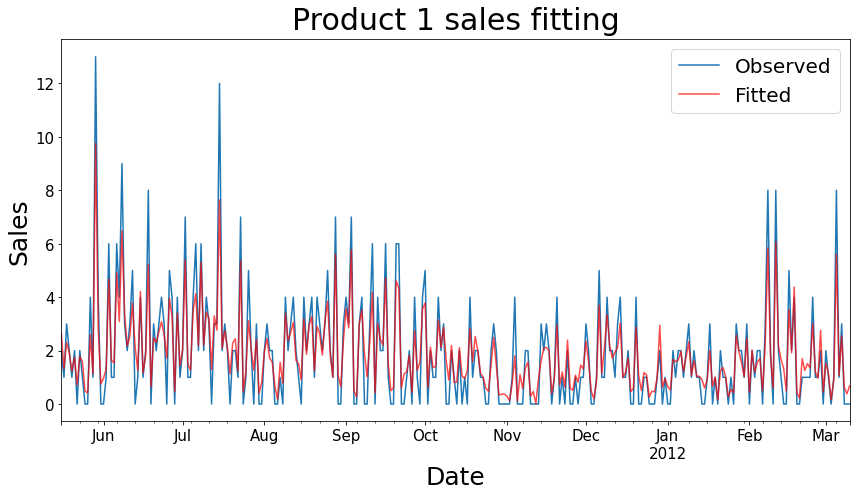

RMSE: 0.87214


In [324]:
# Select only one model to fit, e.g. best_RFR[0]
fittingShow(best_RFR,"Product 1 sales fitting")

In [ ]:
# TODO: now it's time to predict. Try to do that

In [84]:
def estimationShow(data, prediction, title):
    fig, axes = plt.subplots(figsize=(12,7))

    axes.set_title(title, fontdict={'fontsize':30}, pad=10)

    labelsize=15
    axes.yaxis.set_tick_params(labelsize=labelsize)
    axes.xaxis.set_tick_params(labelsize=labelsize)

    (data/1000)[-1000:].plot(ax=axes)
    (prediction.future/1000).plot(ax=axes,color='r', alpha=0.7)

    axes.set_ylabel('Sales, k', fontsize=25)
    axes.set_xlabel('Date', fontsize=25)

    axes.legend(['Observed','Predicted'], fontsize=20, loc='lower left')
    
    plt.tight_layout()
    plt.show()

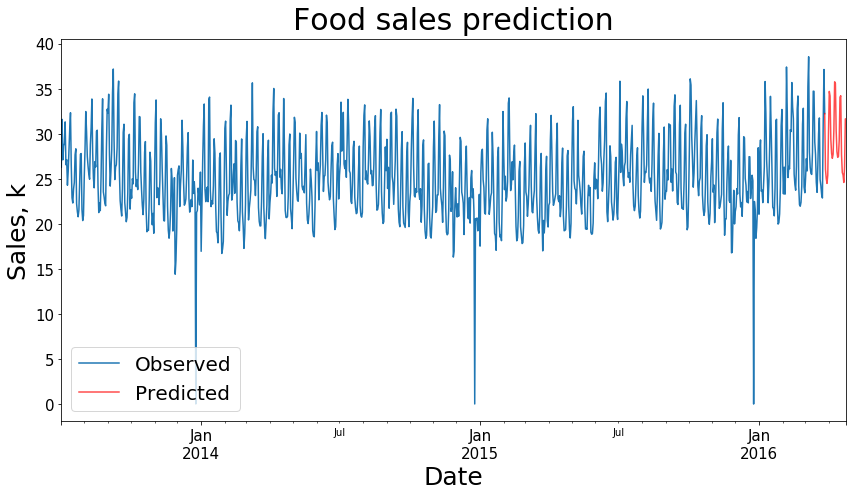

In [85]:
estimationShow(train.food, food_comparison, 'Food sales prediction')

In [88]:
def estimationCompare(data, prediction, title):
    fig, axes = plt.subplots(figsize=(12,7))

    axes.set_title(title, fontdict={'fontsize':30}, pad=10)

    labelsize=15
    axes.yaxis.set_tick_params(labelsize=labelsize)
    axes.xaxis.set_tick_params(labelsize=labelsize)

    (data/1000)[-100:].plot(ax=axes)
    (prediction.future/1000).plot(ax=axes,color='r', alpha=0.7)
    (prediction.sales/1000).plot(color='g')

    axes.set_ylabel('Sales, k', fontsize=25)
    axes.set_xlabel('Date', fontsize=25)

    axes.legend(['Observed','Predicted', 'Test'], fontsize=20, loc='lower right')
    
    plt.tight_layout()
    plt.show()

    print('SMAPE = %.5f%%' % smape(prediction.sales[1:],prediction.future[1:]))

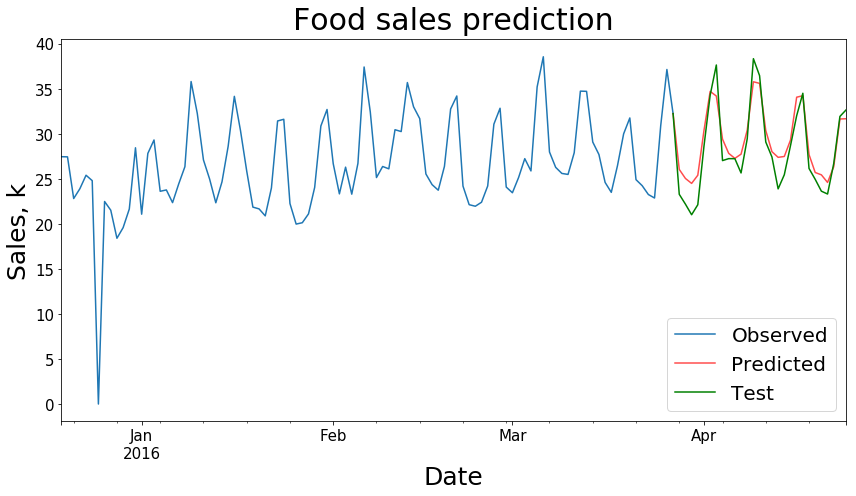

SMAPE = 2.92324%


In [89]:
estimationCompare(train.food, food_comparison, 'Food sales prediction')

In [11]:
beginning='2013-11-30'
ending='2015-06-13'

events=calendar.drop(columns=['wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'd', 'event_name_2',
                           'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI'])
events['date']=pd.to_datetime(events['date'])
events.dropna(inplace=True)

events=events[(events.event_name_1 == 'Halloween') | (events.event_name_1 == 'Mother\'s day')
              | (events.event_name_1 == 'Easter') | (events.event_name_1 == 'NewYear')
             | (events.event_name_1 == 'IndependenceDay')]
events=events[(events.date < ending) & (events.date > beginning)]

events.columns = ['date', 'name', 'type']
events.reset_index(drop=True, inplace=True)
events=events.drop(index=2)
events.reset_index(drop=True, inplace=True)

In [16]:
def holidaysShow(dataframe):
    fig, axes = plt.subplots(figsize=(12,6))
    plt.title('Holidays', size=30)

    plt.plot(dataframe.sales[beginning:ending], label='Product 1')

    axes.set_xlabel('Date', size=25)
    axes.set_ylabel('Food sales, k', size=25)
    axes.yaxis.set_tick_params(labelsize=15)
    axes.xaxis.set_tick_params(labelsize=15)

    start,end = axes.get_ylim()[0],axes.get_ylim()[1]
    plt.vlines(events.date, start,end,linestyles='--',color='r',alpha = 0.5)

    for i in range(0,len(events.name)):
            plt.text(events.date[i],end,events.name[i])

    plt.tight_layout()
    plt.show()

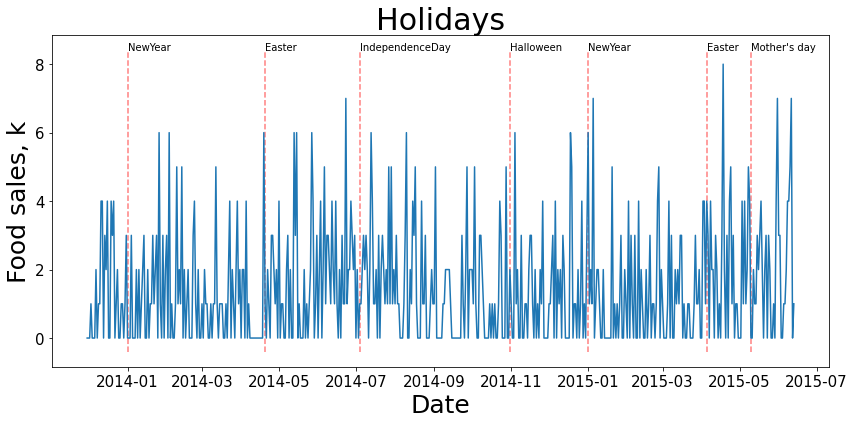

In [22]:
holidaysShow(data[0])

### SNAP - Supplemental Nutrition Assistance Program

In [23]:
snap=calendar.drop(columns=['wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'd', 'event_name_1',
                           'event_type_1', 'event_name_2', 'event_type_2'])
snap['date']=pd.to_datetime(snap['date'])
snap.set_index('date', inplace=True)

snap['snap_CA'] = snap['snap_CA'].astype('float')
snap['snap_TX'] = snap['snap_TX'].astype('float')
snap['snap_WI'] = snap['snap_WI'].astype('float')

snap.head()

,snap_CA,snap_TX,snap_WI
date,,,
2011-01-29,0.0,0.0,0.0
2011-01-30,0.0,0.0,0.0
2011-01-31,0.0,0.0,0.0
2011-02-01,1.0,1.0,0.0
2011-02-02,1.0,0.0,1.0


In [36]:
def showSnap():
    fig, ax = plt.subplots(nrows=1, figsize=(16,12))
    calmap.yearplot(snap.snap_CA, year=2015, ax=ax)
    ax.yaxis.set_tick_params(labelsize=15)
    ax.xaxis.set_tick_params(labelsize=15)

    plt.tight_layout()
    plt.show()

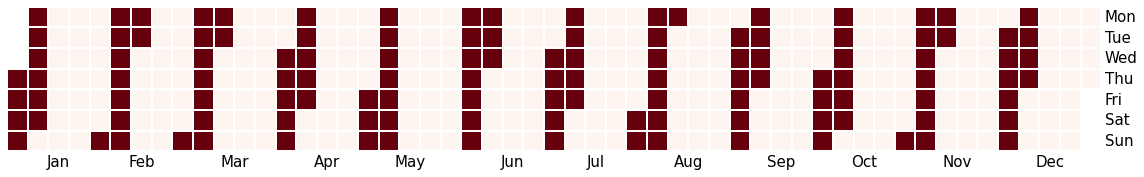

In [37]:
showSnap()

# Feature engineering

In [48]:
to_concat = list()
names = list()
for i, d in enumerate(data):
    to_concat.append(pd.DataFrame(d.sales))
    names.append("Product "+str(i))
    
sales = pd.concat(to_concat, axis=1)
sales.columns = names
sales.head()

,Product 0,Product 1,Product 2,Product 3,Product 4
date,,,,,
2011-02-05,1.0,1.0,5.0,0.0,1.0
2011-02-06,0.0,0.0,12.0,2.0,1.0
2011-02-07,0.0,1.0,4.0,1.0,1.0
2011-02-08,0.0,0.0,7.0,4.0,0.0
2011-02-09,0.0,0.0,9.0,3.0,2.0


In [49]:
weekday_features=calendar.drop(columns=['wm_yr_wk', 'wday', 'd', 'month', 'year', 'event_name_2', 'event_name_1',
                           'event_type_2', 'event_type_1', 'snap_CA', 'snap_TX', 'snap_WI'])
weekday_features['date']=pd.to_datetime(weekday_features['date'])
weekday_features.set_index('date', inplace=True)

weekday_features['is_saturday'] = weekday_features['weekday'] == 'Saturday'
weekday_features['is_saturday'] = weekday_features['is_saturday'].astype('float')

weekday_features['is_sunday'] = weekday_features['weekday'] == 'Sunday'
weekday_features['is_sunday'] = weekday_features['is_sunday'].astype('float')

weekday_features['is_monday'] = weekday_features['weekday'] == 'Monday'
weekday_features['is_monday'] = weekday_features['is_monday'].astype('float')

weekday_features['is_friday'] = weekday_features['weekday'] == 'Friday'
weekday_features['is_friday'] = weekday_features['is_friday'].astype('float')

weekday_features.drop(columns=['weekday'], inplace=True)
weekday_features.head()

,is_saturday,is_sunday,is_monday,is_friday
date,,,,
2011-01-29,1.0,0.0,0.0,0.0
2011-01-30,0.0,1.0,0.0,0.0
2011-01-31,0.0,0.0,1.0,0.0
2011-02-01,0.0,0.0,0.0,0.0
2011-02-02,0.0,0.0,0.0,0.0


In [50]:
events_features=calendar.drop(columns=['wm_yr_wk', 'weekday', 'year', 'd', 'wday', 'month',
                                       'snap_CA', 'snap_TX', 'snap_WI'])
events_features['date']=pd.to_datetime(events_features['date'])

events_features['is_day_off'] = (events_features.date.dt.day == 25) & (events_features.date.dt.month == 12)
events_features['is_day_off'] = events_features['is_day_off'].astype('float')

events_features.set_index('date', inplace=True)

events_features['is_sporting'] = (events_features.event_type_1 == 'Sporting') | (events_features.event_type_2 == 'Sporting')
events_features['is_sporting'] = events_features['is_sporting'].astype('float')

events_features['is_cultural'] = (events_features.event_type_1 == 'Cultural') | (events_features.event_type_2 == 'Cultural')
events_features['is_cultural'] = events_features['is_cultural'].astype('float')

events_features['is_national'] = (events_features.event_type_1 == 'National') | (events_features.event_type_2 == 'National')
events_features['is_national'] = events_features['is_national'].astype('float')

events_features['is_religious'] = (events_features.event_type_1 == 'Religious') | (events_features.event_type_2 == 'Religious')
events_features['is_religious'] = events_features['is_religious'].astype('float')

events_features.drop(columns=['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2'], inplace=True)

events_features.head()

,is_day_off,is_sporting,is_cultural,is_national,is_religious
date,,,,,
2011-01-29,0.0,0.0,0.0,0.0,0.0
2011-01-30,0.0,0.0,0.0,0.0,0.0
2011-01-31,0.0,0.0,0.0,0.0,0.0
2011-02-01,0.0,0.0,0.0,0.0,0.0
2011-02-02,0.0,0.0,0.0,0.0,0.0


In [61]:
tomorrow_features = events_features.reset_index()

tomorrow_features.date = tomorrow_features.date - timedelta(days=1)
tomorrow_features.drop(tomorrow_features.head(1).index, inplace=True)

last=tomorrow_features.loc[1]
last.date=tomorrow_features.loc[len(tomorrow_features)].date + timedelta(days=1)
tomorrow_features.loc[len(tomorrow_features)+1]=last
tomorrow_features.loc[len(tomorrow_features)].date=date

tomorrow_features.set_index('date', inplace=True)
tomorrow_features.columns = tomorrow_features.columns + '_tomorrow'

tomorrow_features.head()

,is_day_off_tomorrow,is_sporting_tomorrow,is_cultural_tomorrow,is_national_tomorrow,is_religious_tomorrow
date,,,,,
2011-01-29,0.0,0.0,0.0,0.0,0.0
2011-01-30,0.0,0.0,0.0,0.0,0.0
2011-01-31,0.0,0.0,0.0,0.0,0.0
2011-02-01,0.0,0.0,0.0,0.0,0.0
2011-02-02,0.0,0.0,0.0,0.0,0.0


In [85]:
collection = pd.concat([sales, weekday_features, events_features, tomorrow_features, snap], axis=1).dropna()
collection.rename(columns={'snap_CA': 'is_discount'}, inplace=True)
collection.head()

,Product 0,Product 1,Product 2,Product 3,Product 4,is_saturday,is_sunday,is_monday,is_friday,is_day_off,...,is_national,is_religious,is_day_off_tomorrow,is_sporting_tomorrow,is_cultural_tomorrow,is_national_tomorrow,is_religious_tomorrow,is_discount,snap_TX,snap_WI
date,,,,,,,,,,,,,,,,,,,,,
2011-02-05,1.0,1.0,5.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0
2011-02-06,0.0,0.0,12.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
2011-02-07,0.0,1.0,4.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2011-02-08,0.0,0.0,7.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2011-02-09,0.0,0.0,9.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0


In [88]:
def showCorrelationDays():
    fig, axes = plt.subplots(figsize=(15,8))

    ind=pd.Index([*names, 'is_saturday',
       'is_sunday', 'is_monday', 'is_friday', 'is_day_off', 'is_discount'])

    sns.heatmap(collection[ind].corr(), annot = True,  cbar=False, ax=axes)

    axes.yaxis.set_tick_params(labelsize=15)
    axes.xaxis.set_tick_params(labelsize=15)
    axes.set_title('Correlation of target and features', fontdict={'fontsize':30}, pad=20)

    plt.yticks(rotation=0) 
    plt.xticks(rotation=-90) 

    plt.show()
    
    print("Target: ", *names)

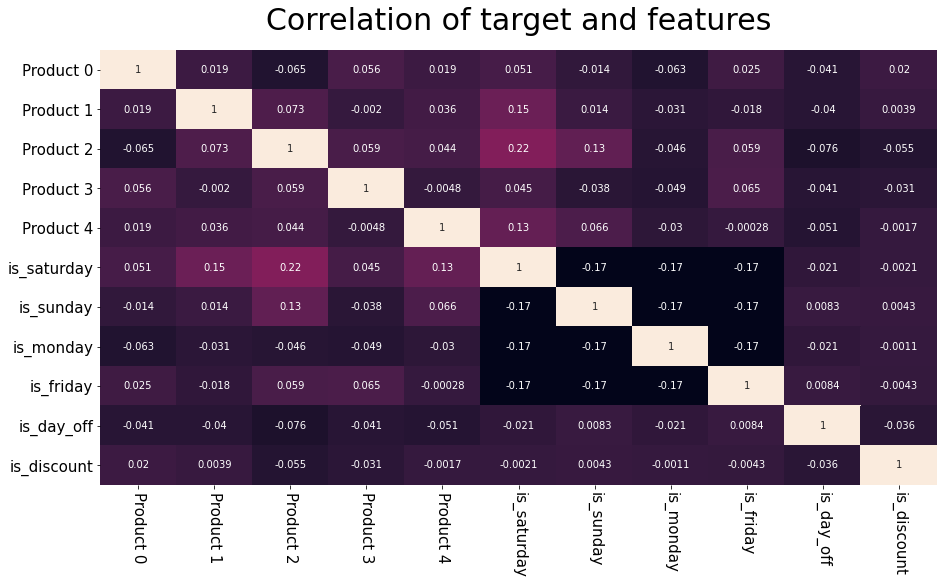

Target:  Product 0 Product 1 Product 2 Product 3 Product 4


In [89]:
showCorrelationDays()

In [90]:
def showCorrelationEvents():
    fig, axes = plt.subplots(figsize=(15,8))

    ind=pd.Index([*names, 'is_sporting', 'is_cultural',
                  'is_national', 'is_religious', 'is_sporting_tomorrow', 'is_cultural_tomorrow',
                  'is_national_tomorrow', 'is_religious_tomorrow'])

    sns.heatmap(collection[ind].corr(), annot = True,  cbar=False, ax=axes)

    axes.yaxis.set_tick_params(labelsize=15)
    axes.xaxis.set_tick_params(labelsize=15)
    axes.set_title('Correlation of target and features', fontdict={'fontsize':30}, pad=20)

    plt.yticks(rotation=0) 
    plt.xticks(rotation=-90) 

    plt.show()
    
    print("Target:", *names)

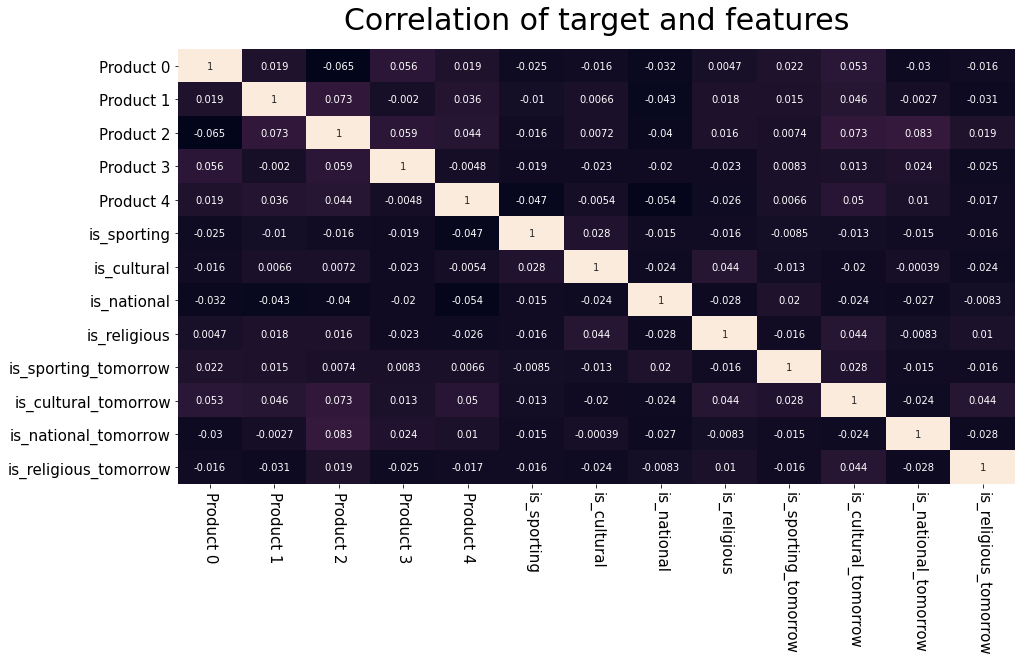

Target: Product 0 Product 1 Product 2 Product 3 Product 4


In [91]:
showCorrelationEvents()

In [100]:
features_columns = ['is_saturday', 'is_sunday', 'is_monday', 'is_friday', 'is_day_off', \
       'is_sporting', 'is_cultural', 'is_national', 'is_religious', \
       'is_day_off_tomorrow', 'is_sporting_tomorrow', 'is_cultural_tomorrow', \
       'is_national_tomorrow', 'is_religious_tomorrow', 'is_discount']

In [115]:
data_with_features = list()
for i, _ in enumerate(data):
    data_with_features.append(pd.concat([data[i], collection[features_columns]], axis=1))

In [116]:
data_with_features[0].head()

,sales,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,is_saturday,is_sunday,...,is_sporting,is_cultural,is_national,is_religious,is_day_off_tomorrow,is_sporting_tomorrow,is_cultural_tomorrow,is_national_tomorrow,is_religious_tomorrow,is_discount
date,,,,,,,,,,,,,,,,,,,,,
2011-02-05,1.0,10.0,2.0,7.0,1.0,3.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2011-02-06,0.0,1.0,10.0,2.0,7.0,1.0,3.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2011-02-07,0.0,0.0,1.0,10.0,2.0,7.0,1.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2011-02-08,0.0,0.0,0.0,1.0,10.0,2.0,7.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2011-02-09,0.0,0.0,0.0,0.0,1.0,10.0,2.0,7.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


# Residues observation

In [73]:
def residues(model, title, pad):
    fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(12,8))

    axes[0].set_title(title, fontdict={'fontsize':30}, pad=20)

    labelsize=15
    axes[0].yaxis.set_tick_params(labelsize=labelsize)
    axes[0].xaxis.set_tick_params(labelsize=labelsize)
    axes[1].yaxis.set_tick_params(labelsize=labelsize)
    axes[1].xaxis.set_tick_params(labelsize=labelsize)

    (model.resid/1000).plot(ax=axes[0], legend=False)
    sm.graphics.tsa.plot_acf(model.resid.values.squeeze(), lags=800, ax=axes[1], markersize=4, title='')

    ylabelsize=20
    axes[0].set_ylabel('Residue, k', fontsize=ylabelsize, labelpad=pad[0])
    axes[0].set_xlabel('Date', fontsize=0)
    axes[1].set_ylabel('Autocorrelation', fontsize=ylabelsize,labelpad=pad[1])

    plt.tight_layout()
    plt.show()

    p_stud=stats.ttest_1samp(model.resid, 0)[1]
    p_adf=sm.tsa.stattools.adfuller(model.resid)[1]

    if p_adf < 0.005:
        str_adf='is rejected completely'
    else:
        str_adf='can not be rejected'
    print("Student's test: p=%.5f. Null hypothesis - residues are unbiased "% p_stud)
    print("Dickey–Fuller test: p=%s\nNull hypothesis - series is non-stationary - "% "{:e}".format(p_adf) + str_adf)

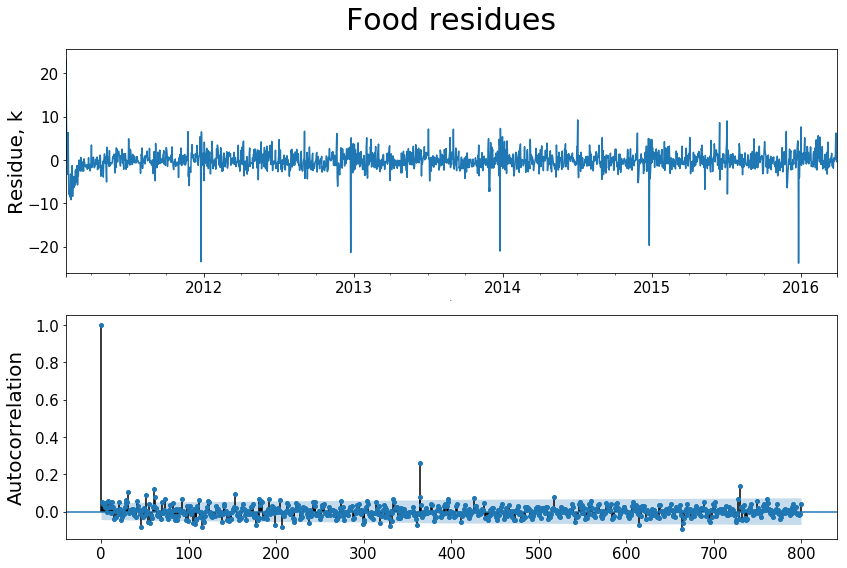

Student's test: p=0.01809. Null hypothesis - residues are unbiased 
Dickey–Fuller test: p=4.606989e-15
Null hypothesis - series is non-stationary - is rejected completely


In [74]:
residues(food_model, 'Food residues', (0,9))

# Prediction

In [81]:
food_future=food_model.predict(start=1885, end=1884+28)
food_future=pd.DataFrame(food_future, columns=['future'])
food_comparison=pd.concat([food_future, test_set.food], axis=1)
food_comparison.rename(columns={'food':'sales'}, inplace=True)
food_comparison.future[0]=food_comparison.sales[0]
food_comparison.head()

,future,sales
2016-03-27,32236.000000,32236.0
2016-03-28,26048.344517,23285.0
2016-03-29,25044.063457,22191.0
2016-03-30,24495.002745,21017.0
2016-03-31,25401.965424,22127.0


In [93]:
def compareFitting(data, models, titles):
    fig, axes = plt.subplots(nrows=2,figsize=(12,8))

    axes[0].set_title(titles[0], fontdict={'fontsize':30}, pad=10)
    axes[1].set_title(titles[1], fontdict={'fontsize':30}, pad=10)

    labelsize=15
    axes[0].yaxis.set_tick_params(labelsize=labelsize)
    axes[0].xaxis.set_tick_params(labelsize=labelsize)
    axes[1].yaxis.set_tick_params(labelsize=labelsize)
    axes[1].xaxis.set_tick_params(labelsize=labelsize)

    ind = np.arange(100,400)
    (data/1000)[ind].plot(ax=axes[0])
    (data/1000)[ind].plot(ax=axes[1])
    (models[0].fittedvalues/1000)[ind].plot(ax=axes[0],color='r', alpha=0.7)
    (models[1].fittedvalues/1000)[ind].plot(ax=axes[1],color='r', alpha=0.7)

    axes[0].set_ylabel('Sales, k', fontsize=25)
    axes[0].set_xlabel('Date', fontsize=25)
    axes[1].set_ylabel('Sales, k', fontsize=25)
    axes[1].set_xlabel('Date', fontsize=25)

    axes[0].legend(['Observed', 'Fitted'], fontsize=20, loc='lower left')
    axes[1].legend(['Observed', 'Fitted'], fontsize=20, loc='lower left')

    plt.tight_layout()
    plt.show()
    
    print('SMAPE: %.5f%% vs %.5f%%' % (smape(data, models[0].fittedvalues),smape(data, models[1].fittedvalues)))

In [94]:
def residuesCompare(models, titles):
    fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(12,8))

    axes[0].set_title(titles[0], fontdict={'fontsize':30}, pad=20)
    axes[1].set_title(titles[1], fontdict={'fontsize':30}, pad=20)

    labelsize=15
    axes[0].yaxis.set_tick_params(labelsize=labelsize)
    axes[0].xaxis.set_tick_params(labelsize=labelsize)
    axes[1].yaxis.set_tick_params(labelsize=labelsize)
    axes[1].xaxis.set_tick_params(labelsize=labelsize)

    (models[0].resid/1000).plot(ax=axes[0], legend=False)
    (models[1].resid/1000).plot(ax=axes[1], legend=False)

    ylabelsize=20
    axes[0].set_ylabel('Residue, k', fontsize=ylabelsize)
    axes[0].set_xlabel('Date', fontsize=0)
    axes[1].set_ylabel('Residue, k', fontsize=ylabelsize)
    axes[1].set_xlabel('Date', fontsize=0)

    plt.tight_layout()
    plt.show()

    p_stud1=stats.ttest_1samp(models[0].resid, 0)[1]
    p_stud2=stats.ttest_1samp(models[1].resid, 0)[1]
    p_adf1=sm.tsa.stattools.adfuller(models[0].resid)[1]
    p_adf2=sm.tsa.stattools.adfuller(models[1].resid)[1]

    print("Student's test: p=%.5f vs p=%.5f"% (p_stud1,p_stud2))
    print("Dickey–Fuller test: p=%s vs p=%s"% ("{:e}".format(p_adf1),"{:e}".format(p_adf2)))
    

In [95]:
def autocorrelationCompare(models, titles):
    fig, axes = plt.subplots(nrows=2,figsize=(12,9))

    labelsize=15
    axes[0].yaxis.set_tick_params(labelsize=labelsize)
    axes[0].xaxis.set_tick_params(labelsize=labelsize)
    axes[1].yaxis.set_tick_params(labelsize=labelsize)
    axes[1].xaxis.set_tick_params(labelsize=labelsize)
    
    sm.graphics.tsa.plot_acf(models[0].resid.values.squeeze(), lags=800, ax=axes[0], markersize=4, title='')
    axes[0].set_ylabel('Autocorrelation', fontsize=25)
    sm.graphics.tsa.plot_acf(models[1].resid.values.squeeze(), lags=800, ax=axes[1], markersize=4, title='')
    axes[1].set_ylabel('Autocorrelation', fontsize=25)

    axes[0].set_title(titles[0], fontdict={'fontsize':30}, pad=10)
    axes[1].set_title(titles[1], fontdict={'fontsize':30}, pad=10)
    
    plt.tight_layout()
    plt.show()

In [96]:
def predictionsCompare(data, predictions, titles):
    fig, axes = plt.subplots(nrows=2,figsize=(12,9))

    axes[0].set_title(titles[0], fontdict={'fontsize':30}, pad=10)
    axes[1].set_title(titles[1], fontdict={'fontsize':30}, pad=10)

    labelsize=15
    axes[0].yaxis.set_tick_params(labelsize=labelsize)
    axes[0].xaxis.set_tick_params(labelsize=labelsize)
    axes[1].yaxis.set_tick_params(labelsize=labelsize)
    axes[1].xaxis.set_tick_params(labelsize=labelsize)

    (data/1000)[-100:].plot(ax=axes[0])
    (predictions[0].future/1000).plot(ax=axes[0],color='r', alpha=0.7)
    (predictions[0].sales/1000).plot(ax=axes[0],color='g')

    (data/1000)[-100:].plot(ax=axes[1])
    (predictions[1].future/1000).plot(ax=axes[1],color='r', alpha=0.7)
    (predictions[1].sales/1000).plot(ax=axes[1],color='g')

    axes[0].set_ylabel('Sales, k', fontsize=25)
    axes[0].set_xlabel('Date', fontsize=25)
    axes[1].set_ylabel('Sales, k', fontsize=25)
    axes[1].set_xlabel('Date', fontsize=25)

    axes[0].legend(['Observed','Predicted', 'Test'], fontsize=20, loc='lower right')
    axes[1].legend(['Observed','Predicted', 'Test'], fontsize=20, loc='lower right')
    
    plt.tight_layout()
    plt.show()
    
    smape1 = smape(predictions[0].sales[1:],predictions[0].future[1:])
    smape2 = smape(predictions[1].sales[1:],predictions[1].future[1:])
    print('SMAPE = %.5f%% vs %.5f%%' % (smape1, smape2))

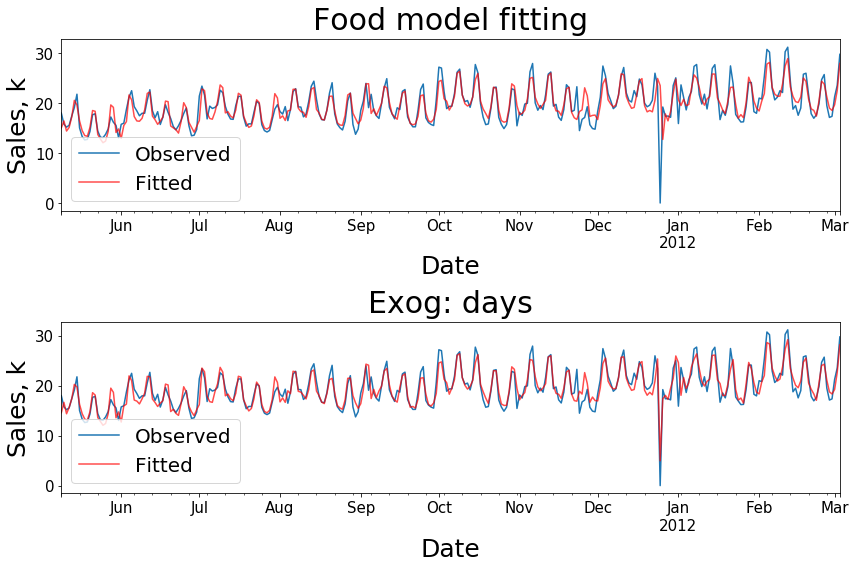

SMAPE: 3.43393% vs 3.33843%


In [108]:
compareFitting(train.food, (food_model,food_model_exog_days), ('Food model fitting','Exog: days'))

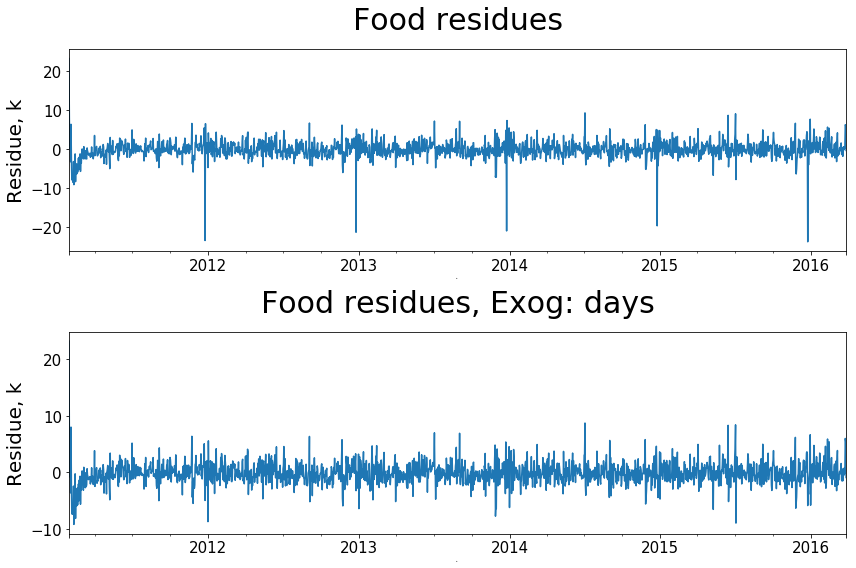

Student's test: p=0.01809 vs p=0.01967
Dickey–Fuller test: p=4.606989e-15 vs p=4.147126e-16


In [111]:
residuesCompare((food_model,food_model_exog_days),('Food residues','Food residues, Exog: days'))

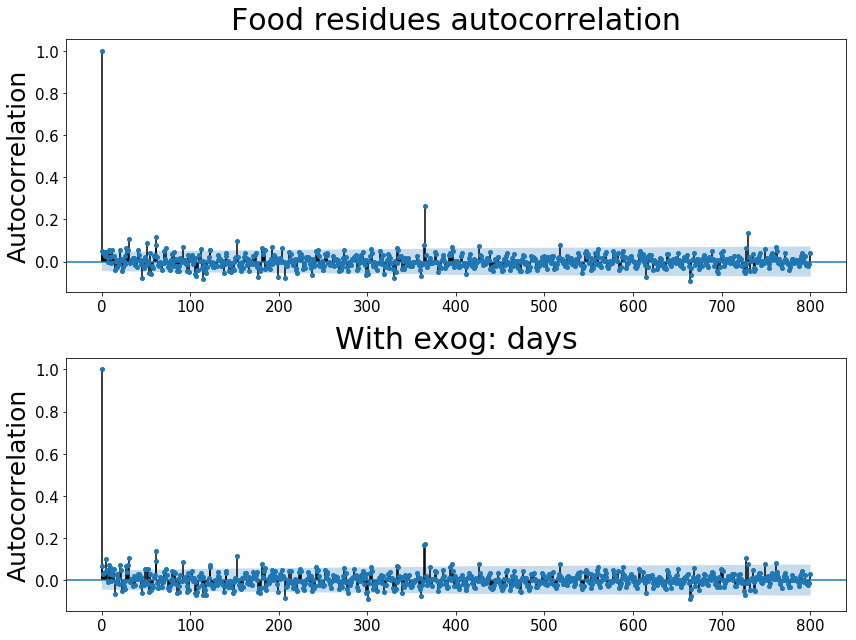

In [114]:
autocorrelationCompare((food_model,food_model_exog_days),('Food residues autocorrelation','With exog: days'))

In [117]:
food_future_exog_days=food_model_exog_days.predict(start=1885, end=1884+28, exog=exog_days_test)
food_future_exog_days=pd.DataFrame(food_future_exog_days, columns=['future'])
food_comparison_exog_days=pd.concat([food_future_exog_days, test_set.food], axis=1)
food_comparison_exog_days.rename(columns={'food':'sales'}, inplace=True)
food_comparison_exog_days.future[0]=food_comparison_exog_days.sales[0]
food_comparison_exog_days.head()

,future,sales
2016-03-27,32236.000000,32236.0
2016-03-28,25988.988159,23285.0
2016-03-29,24998.147220,22191.0
2016-03-30,24103.041507,21017.0
2016-03-31,25012.501517,22127.0


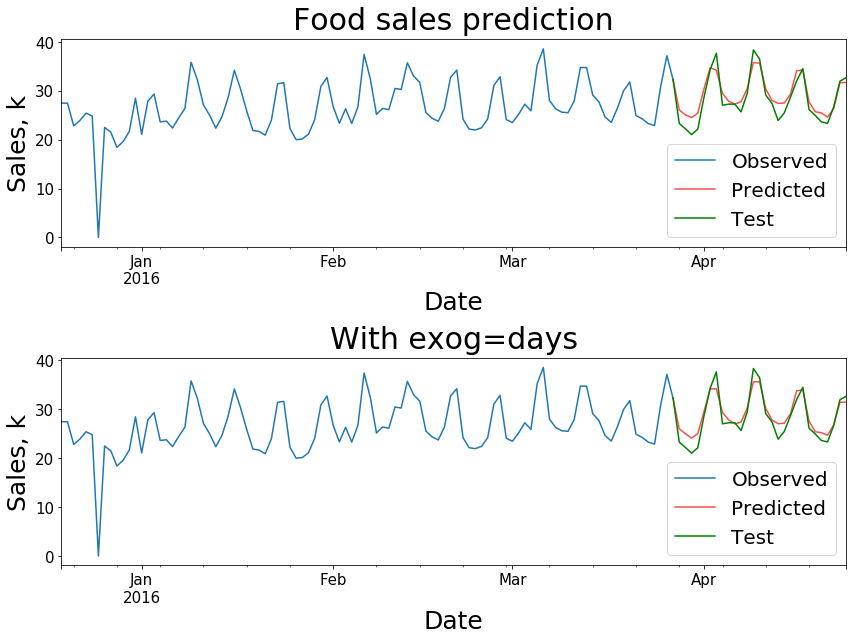

SMAPE = 2.92324% vs 2.66326%


In [120]:
predictionsCompare(train.food, (food_comparison, food_comparison_exog_days), ('Food sales prediction','With exog=days'))

# Results

In [168]:
# ARIMA:
a1="%.2f" % (smape(food_comparison.sales[1:],food_comparison.future[1:]))
a2="%.2f" % (smape(hobbies_comparison.sales[1:],hobbies_comparison.future[1:]))
a3="%.2f" % (smape(household_comparison.sales[1:],household_comparison.future[1:]))

# ARIMA + days
b1="%.2f" % (smape(food_comparison_exog_days.sales[1:],food_comparison_exog_days.future[1:]))
b2="%.2f" % (smape(hobbies_comparison_exog_days.sales[1:],hobbies_comparison_exog_days.future[1:]))
b3="%.2f" % (smape(household_comparison_exog_days.sales[1:],household_comparison_exog_days.future[1:]))

# ARIMA + events
c1="%.2f" % (smape(food_comparison_exog_events.sales[1:],food_comparison_exog_events.future[1:]))
c2="%.2f" % (smape(hobbies_comparison_exog_events.sales[1:],hobbies_comparison_exog_events.future[1:]))
c3="%.2f" % (smape(household_comparison_exog_events.sales[1:],household_comparison_exog_events.future[1:]))

# ARIMA + snap
d1="%.2f" % (smape(food_comparison_exog_snap.sales[1:],food_comparison_exog_snap.future[1:]))
d2="%.2f" % (smape(hobbies_comparison_exog_snap.sales[1:],hobbies_comparison_exog_snap.future[1:]))
d3="%.2f" % (smape(household_comparison_exog_snap.sales[1:],household_comparison_exog_snap.future[1:]))

statistics={'pure ARIMA' : [a1, a2, a3], 'exog=days' : [b1, b2, b3],
           'exog=events' : [c1, c2, c3], 'exog=snap' : [d1, d2, d3]}

statistics=pd.DataFrame(statistics, index=('food','hobbies','household'), columns=('pure ARIMA',
                                                            'exog=days', 'exog=events','exog=snap'))
statistics = statistics + '%'

statistics

,pure ARIMA,exog=days,exog=events,exog=snap
food,2.92%,2.66%,2.83%,2.37%
hobbies,2.82%,2.80%,3.02%,2.88%
household,2.76%,3.02%,3.20%,2.46%


In [178]:
boldList = ('2.66%', '2.83%', '2.37%', '2.46%', '2.80%')

def makeBold(x):
    if x in boldList:
        return 'font-weight: bold'
    else:
        return ''

statForPrint=statistics.style.applymap(makeBold)

In [172]:
def showResults():

    print('Metrics: SMAPE')
    
    return statForPrint

In [179]:
showResults()

Metrics: SMAPE


,pure ARIMA,exog=days,exog=events,exog=snap
food,2.92%,2.66%,2.83%,2.37%
hobbies,2.82%,2.80%,3.02%,2.88%
household,2.76%,3.02%,3.20%,2.46%


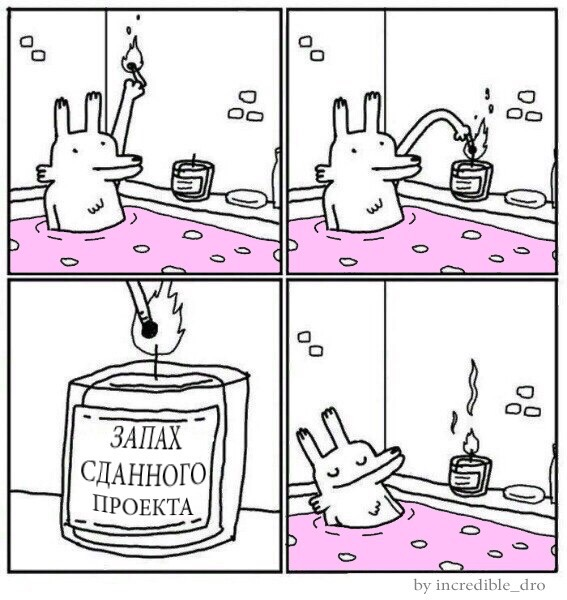

In [4]:
Image(filename='lol.jpg')